In [49]:
import torch
import numpy as np

from utils import npmse
import os
import argparse

# Optimizer
from torch.optim import Adam, Adamax

# Custom modules
import dataloading
import model_class

# metric 
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt  
"""
parser = argparse.ArgumentParser()

# data params
parser.add_argument('--dataset', type=str, default="SWAN")

# Model params
parser.add_argument('--hidden_units', type=eval, default=[100,100,100]) # Controls MLP Hidden nodes
parser.add_argument('--model', type=str, default='SWAN_LSTM', choices={'MLP', 'RNN', "RNN_FULL", "SWAN_LSTM"})
parser.add_argument('--activation', type=str, default='gelu', choices={'relu', 'elu', 'gelu'})
#parser.add_argument('--range_flow', type=str, default='logit', choices={'logit', 'softplus'})
parser.add_argument('--log_transform', type=eval, default=False)

# Train params
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--batch_size', type=int, default=16)
parser.add_argument('--optimizer', type=str, default='adam', choices={'adam', 'adamax'})
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--device', type=str, default='cpu')
"""

'\nparser = argparse.ArgumentParser()\n\n# data params\nparser.add_argument(\'--dataset\', type=str, default="SWAN")\n\n# Model params\nparser.add_argument(\'--hidden_units\', type=eval, default=[100,100,100]) # Controls MLP Hidden nodes\nparser.add_argument(\'--model\', type=str, default=\'SWAN_LSTM\', choices={\'MLP\', \'RNN\', "RNN_FULL", "SWAN_LSTM"})\nparser.add_argument(\'--activation\', type=str, default=\'gelu\', choices={\'relu\', \'elu\', \'gelu\'})\n#parser.add_argument(\'--range_flow\', type=str, default=\'logit\', choices={\'logit\', \'softplus\'})\nparser.add_argument(\'--log_transform\', type=eval, default=False)\n\n# Train params\nparser.add_argument(\'--epochs\', type=int, default=50)\nparser.add_argument(\'--batch_size\', type=int, default=16)\nparser.add_argument(\'--optimizer\', type=str, default=\'adam\', choices={\'adam\', \'adamax\'})\nparser.add_argument(\'--lr\', type=float, default=1e-3)\nparser.add_argument(\'--device\', type=str, default=\'cpu\')\n'

In [339]:
class Args:
  """
  For jupyter notebook, we should specify args parameters manually 
  """  
    
  dataset = "SWAN"
  hidden_units = [100,100]
  model = 'SWAN_LSTM'
  activation = 'gelu'
  device = 'cpu'
  batch_size = 16
  optimizer = 'adam'
  lr = 1e-3 

args=Args()

In [340]:
# Set your device
args.device = torch.device('cuda:{}'.format(0))

# First load datasets
train_loader, test_loader = dataloading.fetch_dataset(args)

# load models

#model = model_class.MLP(16, 1, args.hidden_units)
#model = model_class.RNN(hidden_units=args.hidden_units)
model = model_class.model_fetcher(args)
model = model.double()

if args.optimizer == 'adam':
    optimizer = Adam(model.parameters(), lr=args.lr)
elif args.optimizer == 'adamax':
    optimizer = Adamax(model.parameters(), lr=args.lr)

print('Training...')
ce = torch.nn.CrossEntropyLoss(ignore_index=0)

Fetching SWAN dataset
Training...


In [341]:
checkpoint = torch.load("./results/models/checkpoint_SWAN_LSTM_scale2_epoch99.pt")
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [342]:
test_X = np.load("./data/SWAN_test_X.npy", allow_pickle=True)
train_X = np.load("./data/SWAN_train_X.npy", allow_pickle=True)
train_Y = np.load("./data/SWAN_train_Y.npy", allow_pickle=True)
test_Y = np.load("./data/SWAN_test_Y.npy", allow_pickle=True)

train_tensor_x = torch.tensor(train_X)
train_tensor_y = torch.tensor(train_Y, dtype=torch.long)

test_tensor_y = torch.tensor(test_Y, dtype=torch.long)
test_tensor_x = torch.tensor(test_X)

In [343]:
# Get predicted Value 
pred = model(test_tensor_x)
print("Model Test output:", pred.shape)

Model Test output: torch.Size([619, 10, 4])


C:\Users\user\Documents\GitHub\DeepCasualInference\model_class.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = self.softmax(out)


In [344]:
tag_pad_idx = 0.0 # This becomes the ignoring idx.. (pad idx)
test_tensor_y = test_tensor_y.view(-1)
pred = pred.view(-1, 4)

In [345]:
test_tensor_y[test_tensor_y==3].shape

torch.Size([1223])

# Evaluating using Metric 

In [346]:
pred = pred.detach().cpu().numpy()
test_y = test_tensor_y.cpu().detach().numpy()

In [347]:
pred.shape

(6190, 4)

In [348]:
tag_pad_idx = 0.0 
non_pad_elements = (test_y != tag_pad_idx).nonzero()

In [349]:
non_pad_elements

(array([   0,    1,    2, ..., 6181, 6182, 6183], dtype=int64),)

## Accurcay (top - 1)

In [350]:
def categorical_accuracy(preds, y, tag_pad_idx=0.0):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    
    preds : (N, C) numpy 
    y : (N, ) numpy 
    """
    max_preds = np.argmax(preds, axis = 1)[:, np.newaxis] # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    print(max_preds.shape, y.shape)
    acc = accuracy_score(max_preds[non_pad_elements], y[non_pad_elements])
    
    return acc 

categorical_accuracy(pred, test_y)

(6190, 1) (6190,)


0.8689927583936801

## ECE error 

In [351]:
scores = pred[non_pad_elements[0]] 
labels = test_y[non_pad_elements]

In [352]:
scores.shape

(4557, 4)

In [353]:
def len0(x) :
  # Proper len function that REALLY works.
  # It gives the number of indices in first dimension

  # Lists and tuples
  if isinstance (x, list) :
    return len(x)

  if isinstance (x, tuple) :
    return len(x)

  # Numpy array
  if isinstance (x, np.ndarray) :
    return x.shape[0]

  # Other numpy objects have length zero
  if is_numpy_object (x) :
    return 0

  # Unindexable objects have length 0
  if x is None :
    return 0
  if isinstance (x, int) :
    return 0
  if isinstance (x, float) :
    return 0

  # Do not count strings
  if type (x) == type("a") :
    return 0

  return 0

In [354]:
c2_scores = scores[:, 1]
c2_order = c2_scores.argsort()

c2_labels = labels[c2_order]
c2_scores = c2_scores[c2_order]

In [355]:
c2_scores[-1]

1.0

In [356]:
c2_cum = (c2_labels==1)

(array([3059.,    0.,    0.,    0.,    0.,  275.,    0.,    0.,    0.,
        1223.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

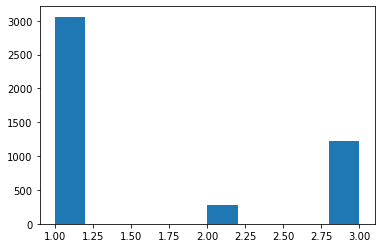

In [357]:
plt.hist(c2_labels)

In [358]:
np.cumsum(c2_cum)

array([   0,    0,    0, ..., 3057, 3058, 3059], dtype=int32)

In [359]:
c2_cum = (c2_labels==1)
c2_cum = np.cumsum(c2_cum)/3059

In [360]:
c2_cum

array([0.        , 0.        , 0.        , ..., 0.99934619, 0.9996731 ,
       1.        ])

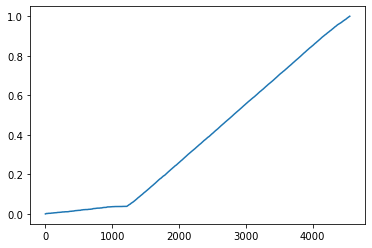

In [361]:
plt.plot(c2_cum)

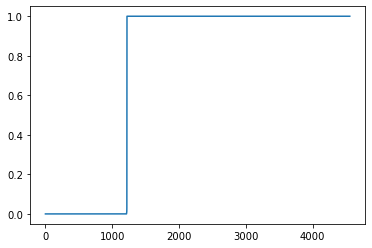

In [362]:
plt.plot(c2_scores)

In [363]:
c2_scores

array([2.17491970e-23, 3.04930367e-23, 4.63145831e-23, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

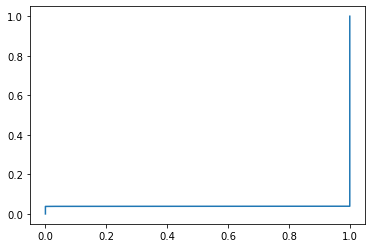

In [364]:
plt.plot(c2_scores,c2_cum)

In [365]:
#nsamples = len0(c2_scores)
nsamples = np.sum((c2_labels==1))
integrated_accuracy = np.cumsum((c2_labels==1))/ nsamples# / nsamples
integrated_scores = np.cumsum(c2_scores) / nsamples
percentile = np.linspace (0.0, 1.0, len(integrated_accuracy))

In [366]:
nsamples

3059

In [367]:
def int_scores(class_label, labels, scores):
    c2_scores = scores[:, class_label]
    c2_order = c2_scores.argsort()

    c2_labels = labels[c2_order]
    c2_scores = c2_scores[c2_order]
    nsamples = np.sum((c2_labels==class_label))
    integrated_accuracy = np.cumsum((c2_labels==class_label))/ nsamples# / nsamples
    integrated_scores = np.cumsum(c2_scores) / nsamples
    percentile = np.linspace (0.0, 1.0, len(integrated_accuracy))
    return percentile, integrated_accuracy, integrated_scores

In [379]:
percentile, integrated_accuracy, integrated_scores = int_scores(3, labels, scores)

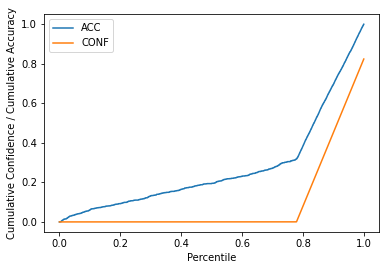

In [380]:
plt.plot(percentile, integrated_accuracy, label="ACC")
plt.plot(percentile, integrated_scores, label="CONF")
plt.xlabel("Percentile")
plt.ylabel("Cumulative Confidence / Cumulative Accuracy")
plt.legend()
plt.show()

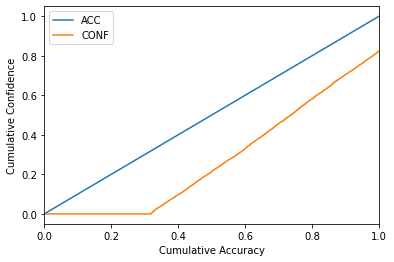

In [381]:
plt.plot(integrated_accuracy, integrated_accuracy, label="ACC")
plt.plot(integrated_accuracy, integrated_scores, label="CONF")

#plt.plot(integrated_scores, integrated_accuracy)
plt.xlim([0,1])
plt.xlabel("Cumulative Accuracy")
plt.ylabel("Cumulative Confidence")
plt.legend()
plt.show()

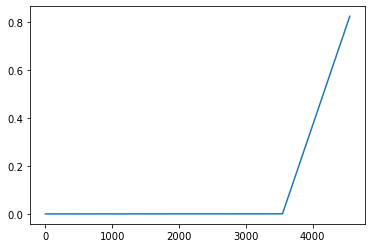

In [382]:
plt.plot(integrated_scores)

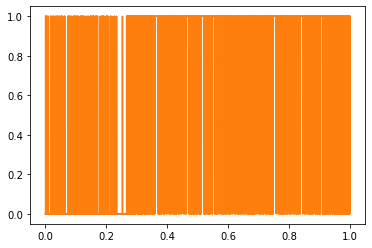

In [372]:
plt.plot(percentile, c2_scores)
plt.plot(percentile, (c2_labels==1))

In [47]:
# Sort the data according to score
order = scores.argsort()
scores = scores[order]
labels = labels[order]

#Accumulate and normalize by dividing by num samples
nsamples = len0(scores)
integrated_accuracy = np.cumsum(labels) / nsamples
integrated_scores = np.cumsum(scores) / nsamples
percentile = np.linspace (0.0, 1.0, nsamples)

In [56]:
scores.shape

(4557, 1, 4, 1, 4, 1, 4, 1, 4)

In [53]:
def get_top_results (scores, labels, nn, inclusive=False, return_topn_classid=False) :

  # Different if we want to take inclusing scores
  if inclusive : return get_top_results_inclusive (scores, labels, nn=nn)

  #  nn should be negative, -1 means top, -2 means second top, etc
  # Get the position of the n-th largest value in each row
  topn = [np.argpartition(score, nn)[nn] for score in scores]
  nthscore = [score[n] for score, n in zip (scores, topn)]
  labs = [1.0 if int(label) == int(n) else 0.0 for label, n in zip(labels, topn)]

  # Change to tensor
  tscores = np.array (nthscore)
  tacc = np.array(labs)

  if return_topn_classid:
    return tscores, tacc, topn
  else:
    return tscores, tacc

In [65]:
tscores, tacc = get_top_results(scores, labels, nn=-1)

(array([1454.,  333.,  336.,  350.,  355.,  349.,  338.,  351.,  342.,
         349.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

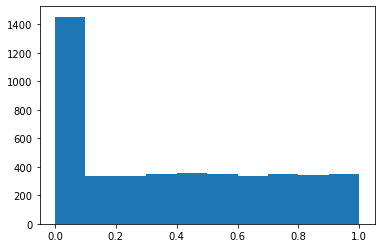

In [183]:
plt.hist(c2_cum)

(array([1214.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3343.]),
 array([2.30105353e-22, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

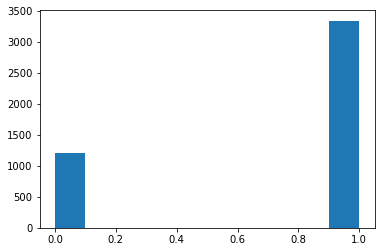

In [169]:
plt.hist(c2_scores)

In [178]:
ECE = ECELoss(1000)
ECE.eval(c2_scores, c2_cum)

array([0.35895161])

In [180]:
ECE.cof

[1.8218607918042434e-06, 0.008102937940360324, 0.9999999792029682]

In [181]:
ECE.acc

[0.018962600594464404, 0.03759398496240601, 0.5175849141771308]

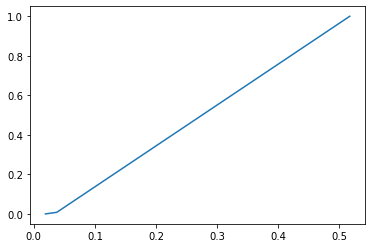

In [179]:
plt.plot(ECE.acc, ECE.cof)

In [172]:
class ECELoss():
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(ECELoss, self).__init__()
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def eval(self, confidences, accuracies):
        ece = np.zeros(1)
        
        acc = []
        cof = []
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.__gt__(bin_lower) * confidences.__le__(bin_upper)
            prop_in_bin = in_bin.astype(float).mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].astype(float).mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
                acc.append(accuracy_in_bin)
                cof.append(avg_confidence_in_bin)
        self.acc = acc
        self.cof = cof 
        return ece

In [ ]:
def ECE(py, y_test, n_bins=10):
    py = np.array(py)
    y_test = np.array(y_test)
    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)
    py_index = np.argmax(py, axis=1)
    py_value = []
    for i in range(py.shape[0]):
        py_value.append(py[i, py_index[i]])
    py_value = np.array(py_value)
    acc, conf = np.zeros(n_bins), np.zeros(n_bins)
    Bm = np.zeros(n_bins)
    for m in range(n_bins):
        a, b = m / n_bins, (m + 1) / n_bins
        for i in range(py.shape[0]):
            if py_value[i] > a and py_value[i] <= b:
                Bm[m] += 1
                if py_index[i] == y_test[i]:
                    acc[m] += 1
                conf[m] += py_value[i]
        if Bm[m] != 0:
            acc[m] = acc[m] / Bm[m]
            conf[m] = conf[m] / Bm[m]
    ece = 0
    for m in range(n_bins):
        ece += Bm[m] * np.abs((acc[m] - conf[m]))
    return ece / sum(Bm)


In [33]:
p1 = pred[non_pad_elements, 1]
p2 = pred[non_pad_elements, 2] + pred[non_pad_elements, 3]

In [34]:
p1.shape

torch.Size([4557, 1])

In [35]:
p2.shape

torch.Size([4557, 1])

In [36]:
p2

tensor([[2.0408e-22],
        [3.1418e-19],
        [1.8476e-17],
        ...,
        [7.4248e-20],
        [2.6364e-19],
        [5.0523e-20]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [37]:
p1

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], dtype=torch.float64, grad_fn=<IndexBackward0>)

In [41]:
pp1 = p1.detach().cpu().numpy()
pp2 = p2.detach().cpu().numpy()

In [53]:
yy = test_tensor_y.detach().cpu().numpy()

In [55]:
yy = yy[non_pad_elements]

In [57]:
yy = yy - 1 

In [58]:
yy

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [59]:
yy[yy==2] = 1

In [68]:
yy[yy==0].shape

(3059,)

In [ ]:
from sklearn.preprocessing import label_binarize
label_binarize()

In [43]:
pp = np.hstack((pp1, pp2))

In [73]:
pp[0]

array([1.00000000e+00, 2.04079048e-22])

In [70]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [76]:
yy

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [77]:
fpr, tpr, _ = roc_curve(yy, pp[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

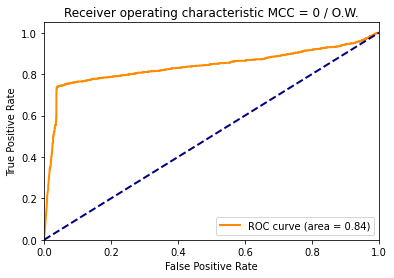

In [93]:
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw = lw, 
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic MCC = 0 / O.W.")
plt.legend(loc="lower right")
plt.show()

In [92]:
from sklearn.metrics import f1_score
f1_score(yy, pp[:,1], average='macro')

ValueError: Classification metrics can't handle a mix of binary and continuous targets